# Assignment 2
Продемонстрировать положение No Free Lunch Theorem. (см материалы семинара)
Качество работы оценивается по accuracy на тестовой выборке согласно пайплайну (см материалы семинара). Метод валидации (если вы его применяете) 5-fold cv.
В выводе для каждой модели указать какие предположения она делает относительно данных. В выводе указать почему модель плохо / хорошо работает на сгенерированной вами выборке. Использовать пространство признаков размерности 2 при классификации и размерности 1 при регрессии. При возможности, нарисовать выборку на графике (цветами обозначить классы).

1. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), на котором метод ближайших соседей работает хуже, чем логистическая регрессия.

2. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), на котором логистическая регрессия работает хуже, чем метод ближайших соседей.

3. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), на котором метод ближайших соседей с косинусной метрикой расстояния работает лучше, чем с евклидовой метрикой.

4. Сгенерировать датасет для задачи регрессии (MSE), на котором решающее дерево работает хуже, чем линейная регрессия

# Source code

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.datasets import make_moons
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def cosine_similarity_distance(x, y):
    return 1 - np.dot(x, y) / np.sqrt(np.dot(x, x) * np.dot(y, y))

def add_intercept_if_is_needed(X, is_needed):
    if is_needed:
        return np.hstack((np.ones((X.shape[0], 1)), X))
    return X

knn_params = {"n_neighbors": [1, 3, 5, 7]}
logreg_params = {"penalty" : ["l1", "l2"], "class_weight" : ["balanced", None], "C" : [0.5, 1, 2]}
dectree_params = {"min_samples_split" : [2, 0.05, 0.1, 0.2]}
linreg_params = {}#[{"fit_intercept" : [False]}, {"normalize" : [True, False]}]

def plot_knn(model, Xmin, ymin, Xmax, ymax):
    pass

def plot_logreg(model, Xmin, ymin, Xmax, ymax):
    # http://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html#sphx-glr-auto-examples-classification-plot-classification-probability-py
    xx = np.linspace(Xmin-0.2, Xmax+0.2, 100)
    yy = np.linspace(ymin-0.2, ymax+0.2, 100).T
    xx, yy = np.meshgrid(xx, yy)
    Xfull = np.c_[xx.ravel(), yy.ravel()]
    probas = model.predict_proba(Xfull)
    _ = plt.imshow(probas[:, 0].reshape((100, 100)), aspect='auto',
                       extent=(Xmin-0.2, Xmax+0.2, ymin-0.2, ymax+0.2), origin='lower')
    if Xmax / ymax > 10:
        print("Draw attention to axis aspect!")
        plt.xlim((Xmin-0.2, ymax * 10 +0.2))
    else:
        plt.xlim((Xmin-0.2, Xmax+0.2))
    plt.ylim((ymin-0.2, ymax+0.2))

def plot_dectree(model, Xmin, ymin, Xmax, ymax):
    X = np.linspace(Xmin, Xmax, 100)
    plt.plot(X, model.predict(X.reshape(-1, 1)), "r", label="DecisionTreeRegressor")

def plot_linreg(model, Xmin, ymin, Xmax, ymax):
    plt.plot([Xmin, Xmax], np.array([Xmin, Xmax]) * model.best_estimator_.coef_[1] + model.best_estimator_.coef_[0], "g", label="LinearRegression")

In [3]:
def plotData(X, y, model1, model2):
    if len(X.shape) > 1:
        if X.shape[1] > 1:
            plt.scatter(X[:,0], X[:,1], c=y)
        else:
            plt.scatter(X[:,0], y)
    else:
        plt.scatter(X, y)
    plt.title(model1 + " is worse than " + model2)
    
def pipeline(X, y, metric, metric_greater_is_better, make_plots, model1, model_params1, model_plot1, model2, model_params2, model_plot2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    scorer = make_scorer(metric, greater_is_better=metric_greater_is_better)
    cvmodel1 = GridSearchCV(eval(model1), model_params1, scoring=scorer, refit=True, cv=5)
    cvmodel2 = GridSearchCV(eval(model2), model_params2, scoring=scorer, refit=True, cv=5)
    cvmodel1.fit(add_intercept_if_is_needed(X_train, model1.find("LinearRegression") != -1), y_train)
    cvmodel2.fit(add_intercept_if_is_needed(X_train, model2.find("LinearRegression") != -1), y_train)
    if make_plots:
        f = plt.figure(figsize=(15,7))
        if len(X.shape) > 1 and X.shape[1] > 1:
            model_plot1(cvmodel1, *X.min(axis=0), *X.max(axis=0))
            model_plot2(cvmodel2, *X.min(axis=0), *X.max(axis=0))
        else:
            model_plot1(cvmodel1, *X.min(axis=0), y.min(axis=0), *X.max(axis=0), y.max(axis=0))
            model_plot2(cvmodel2, *X.min(axis=0), y.min(axis=0), *X.max(axis=0), y.max(axis=0))
        plotData(X, y, model1, model2)
        if model1.find("cosine") != -1 or model2.find("cosine") != -1:
            plt.plot([0, X.max(axis=0)[0]], [0, X.max(axis=0)[1]], "r--")
        plt.legend()
        plt.grid()
        plt.show()
    return (model1, metric(y_test, cvmodel1.predict(add_intercept_if_is_needed(X_test, model1.find("LinearRegression") != -1))),
            model2, metric(y_test, cvmodel2.predict(add_intercept_if_is_needed(X_test, model2.find("LinearRegression") != -1))))

# Задание № 1 
### Датасет, на котором метод ближайших соседей работает хуже, чем логистическая регрессия.

No handles with labels found to put in legend.


Draw attention to axis aspect!


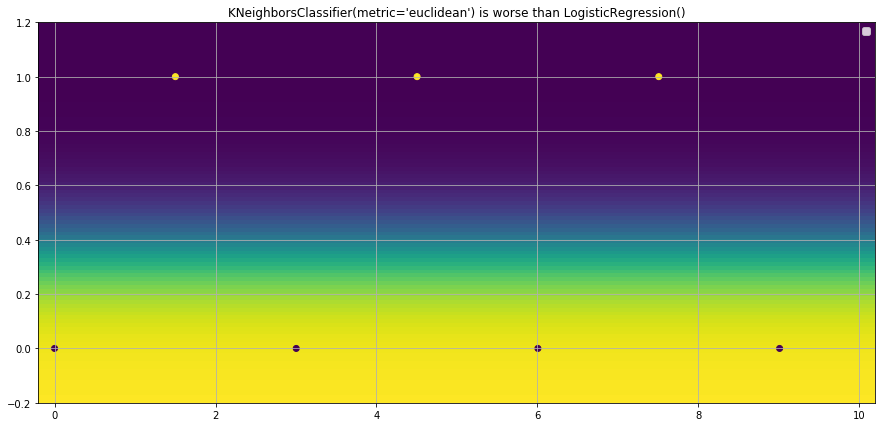

Accuracy for KNeighborsClassifier(metric='euclidean'): 0.32666666666666666 ; for LogisticRegression(): 1.0


In [4]:
def make_parallels(n_samples=100) :
    if n_samples % 2 != 0:
        raise ValueError('n_samples must be even!')
    X = np.zeros((n_samples, 2))
    if n_samples == 0:
        return X, np.array([])
    X[:, 0] = np.linspace(0, n_samples * 1.5, n_samples)
    X[:, 1] = y = np.tile([0, 1], n_samples // 2)
    return X, y
    
    
X, y = make_parallels(n_samples=1000)
res = pipeline(X, y, accuracy_score, True, True, "KNeighborsClassifier(metric='euclidean')", knn_params, plot_knn,
                                                 "LogisticRegression()", logreg_params, plot_logreg)
print("Accuracy for {}: {} ; for {}: {}".format(*res))
    #print(noise, res[1]-res[3])

# Задание № 2
### Датасет, на котором логистическая регрессия работает хуже, чем метод ближайших соседей.

No handles with labels found to put in legend.


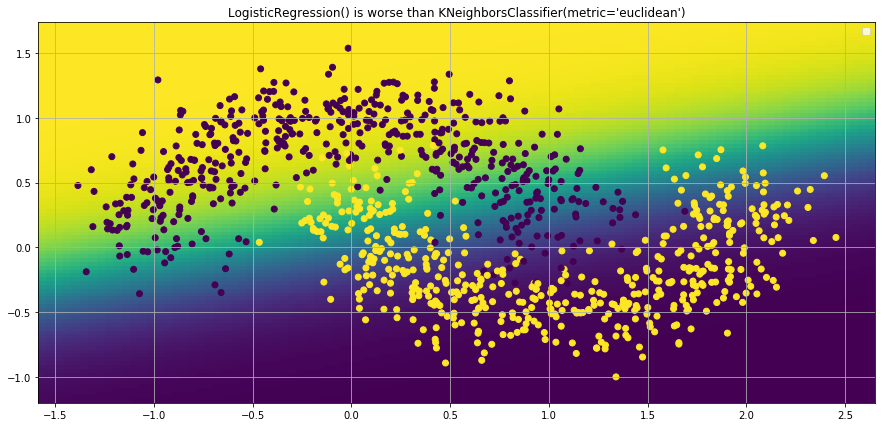

Accuracy for LogisticRegression(): 0.88 ; for KNeighborsClassifier(metric='euclidean'): 0.96


In [5]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
res = pipeline(X, y, accuracy_score, True, True, "LogisticRegression()", logreg_params, plot_logreg,
                                                  "KNeighborsClassifier(metric='euclidean')", knn_params, plot_knn)
print("Accuracy for {}: {} ; for {}: {}".format(*res))


# Задание № 3
### Датасет, на котором метод ближайших соседей с косинусной метрикой расстояния работает лучше, чем с евклидовой метрикой.

No handles with labels found to put in legend.


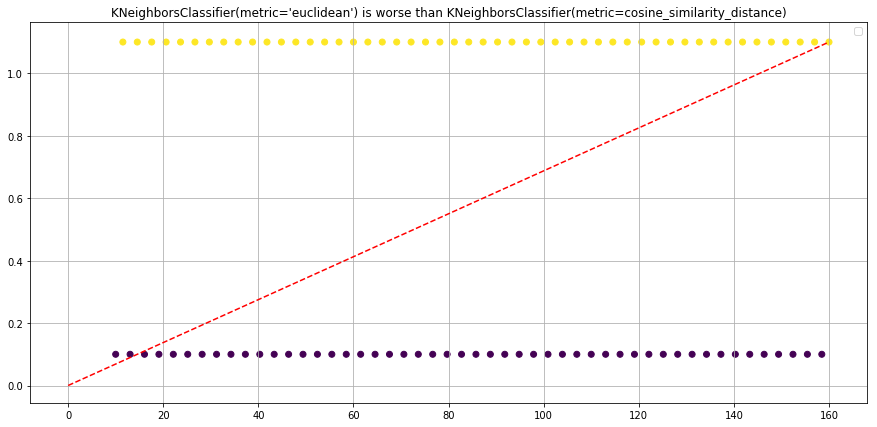

Accuracy for KNeighborsClassifier(metric='euclidean'): 0.43333333333333335 ; for KNeighborsClassifier(metric=cosine_similarity_distance): 1.0


In [6]:
X, y = make_parallels(n_samples=100)
X[:,0] += 10
X[:,1] += 0.1
res = pipeline(X, y, accuracy_score, True, True, "KNeighborsClassifier(metric='euclidean')", knn_params, plot_knn,
                                                "KNeighborsClassifier(metric=cosine_similarity_distance)", knn_params, plot_knn)
print("Accuracy for {}: {} ; for {}: {}".format(*res))

# Задание № 4
### Датасет, на котором решающее дерево работает хуже, чем линейная регрессия.

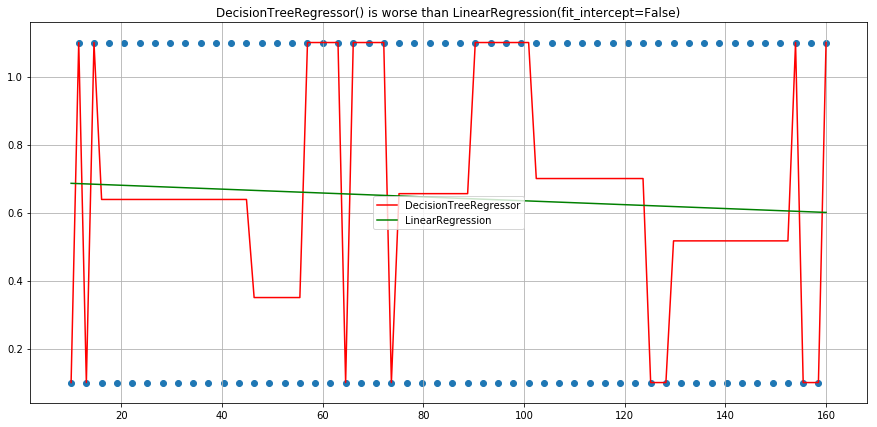

MSE for DecisionTreeRegressor(): 0.5296467662600141 ; for LinearRegression(fit_intercept=False): 0.26556896576687916


In [7]:
X, y = make_parallels(n_samples=100)
X[:,0] += 10
X[:,1] += 0.1
res = pipeline(X[:,0].reshape(-1, 1), X[:,1], mean_squared_error, False, True, "DecisionTreeRegressor()", dectree_params, plot_dectree,
                                                 "LinearRegression(fit_intercept=False)", linreg_params, plot_linreg)
print("MSE for {}: {} ; for {}: {}".format(*res))